# Visualisation of the training data

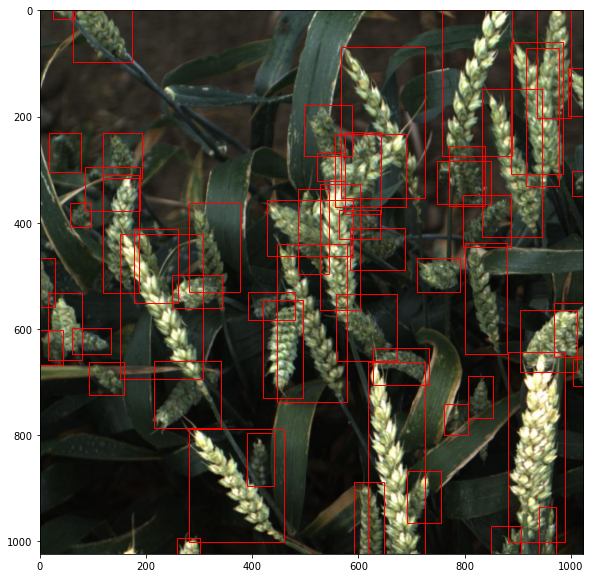

In [ ]:
import os
import cv2
import csv
import glob
import pandas as pd
import numpy as np
import random
import itertools
from collections import Counter
from math import ceil
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

from matplotlib.patches import Rectangle
from PIL import Image


Let's see the list of files in the given dataset

In [ ]:
os.listdir('../input/global-wheat-detection')

import the training data

In [ ]:


train = pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")  
image_folder_path = "/kaggle/input/global-wheat-detection/train/"



In [ ]:
train

In [ ]:
train.nunique()

let's analyse the columns of the train csv file 
* image_id: is the id of the image of the wheat plants there are multipe columns with the same id because a photo has multiple wheat buds which we are going to identify. 
*  width, height : it is the aspect ratio of the image . these are same all images, so later can be excluded
* bbox: it is list containg four elements. first two eare the co-ordinates of the bottom left point of the rectangular box drawn around the wheat bud, and the remaining two are the width and height of the box.
* souce: sorce from which the image data is obtained , not impact on the data

* the bbox column has x_min, y_min,width, hight values in it so split the values and create new coumns
* replace width , height with width , height data of the bounding box
* create new columns for top right point of the bounding box (necessary for some visualisations)

In [ ]:


train['bbox'] = train['bbox'].apply(lambda x: x[1:-1].split(","))
train['x_min'] = train['bbox'].apply(lambda x: x[0]).astype('float32')
train['y_min'] = train['bbox'].apply(lambda x: x[1]).astype('float32')
train['width'] = train['bbox'].apply(lambda x: x[2]).astype('float32')
train['height'] = train['bbox'].apply(lambda x: x[3]).astype('float32')
train = train[['image_id','x_min', 'y_min', 'width', 'height']]
train["x_max"] = train.apply(lambda col: col.x_min + col.width, axis=1)
train["y_max"] = train.apply(lambda col: col.y_min + col.height, axis = 1)
train.head()



* now let's check if there are images with bounding box co-ordinates outside the aspect ratio and correct them

In [ ]:


train[train["x_max"] > 1024]




In [ ]:
train[train["y_max"] > 1024]


In [ ]:
train[train["x_min"] < 0]


In [ ]:
train[train["y_min"] < 0]

In [ ]:
x_max = np.array(train["x_max"].values.tolist())
y_max = np.array(train["y_max"].values.tolist())
train["x_max"] = np.where(x_max > 1024, 1024, x_max).tolist()
train["y_max"] = np.where(y_max > 1024, 1024, y_max).tolist()

* create a column class to classify the the data either having the bboc co-ordinates or not,all the data this in train csv have bbox co-ordinates so fill it with '1' 

In [ ]:
train["class"] = "1"

* now let's check if all the images are jpg are not

In [ ]:
def check_file_type(image_folder_path):
    extension_type = []
    file_list = os.listdir(image_folder_path)
    for file in file_list:
        extension_type.append(file.rsplit(".", 1)[1].lower())
    print(Counter(extension_type).keys())
    print(Counter(extension_type).values())
    
    
check_file_type(image_folder_path)


* now we have to change the image_id in the same format as image name with file extension so that we can map images with data using image_id easily

In [ ]:
train["image_id"] = train["image_id"].apply(lambda x: str(x) + ".jpg")
train.head()

In [ ]:
train["image_id"] = train["image_id"].astype("str")

* now let's save the processesd dataframe into csv file for further use

In [ ]:
train.to_csv("wheat.csv", index=False)

* now we have to check if all the images in train path are of same shape

In [ ]:


def check_image_size(image_folder_path):
    total_img_list = glob.glob(os.path.join(image_folder_path,"*"))
    counter = 0
    for image in tqdm(total_img_list, desc = "Checking in progress"):
        try:
            img = cv2.imread(image)
            height, width = img.shape[1], img.shape[0]
            if not (height == 1024 and width == 1024):
                counter = counter + 1
        except:
            print("This {} is problematic.".format(image))
    return counter 
        
        



In [ ]:


check_image_size(image_folder_path)



In [ ]:
wheat = pd.read_csv("wheat.csv") 
image_folder_path = "/kaggle/input/global-wheat-detection/train/"
image_annotation_file = "wheat.csv"

In [ ]:
wheat.head()

* now we have to check if all the images in the train dataset have bbox information in the csv file

In [ ]:


def sanity_tally(image_folder_path, image_annotation_file):
    img_annotation_list=[]
    with open(image_annotation_file, "r") as file:
        next(file)
        for row in file:
            try:
                image_name, x_min, y_min,width,height ,x_max, y_max, class_idx = row.split(",")
                if image_name not in  img_annotation_list:
                     img_annotation_list.append(image_name)
                
            except ValueError:
                print("Could not convert float to string, likely that your data has empty values.")
        
    
    total_img_list = os.listdir(image_folder_path)
    if set(img_annotation_list) == set(total_img_list):
        print("Sanity Check Status: True")
    else:
        print("Sanity Check Status: Failed. \nThe elements in wheat/train.csv but not in the train image folder is {}. \nThe elements in train image folder but not in wheat/train.csv is {}".format(
                set(img_annotation_list) - set(total_img_list), set(total_img_list) - set(img_annotation_list)))
        return list(set(img_annotation_list) - set(total_img_list)), list(set(total_img_list) - set(img_annotation_list))



In [ ]:
set_diff1, set_diff2 = sanity_tally(image_folder_path, image_annotation_file = image_annotation_file)

print("\n\nThere are {} images without annotations in the train/wheat.csv".format(len(set_diff2)))
print('\n\nThere are {} images that are in train_csv but not in train images'.format(len(set_diff1)))

* we have some images in train folder which have no data in csv file that means they have no wheat buds in them . we will append this in our data after our vusalisations are done

* now let's plot some random images from the train dataset

In [ ]:
def plot_multiple_img(list1):
    f, axarr = plt.subplots(4,3,figsize=(16,12))

    k=0
    for i in range(0,4):
        for j in range(0,3):
            axarr[i,j].imshow(list1[k])
            k+=1


In [ ]:


def plot_random_images(image_folder_path, image_annotation_file, num = 12):
    img_annotation_list=[]
    with open(image_annotation_file, "r") as file:
        next(file)
        for row in file:
            try:
                image_name, x_min, y_min,width,height ,x_max, y_max, class_idx = row.split(",")
                if image_name not in  img_annotation_list:
                     img_annotation_list.append(image_name)
                
            except ValueError:
                print("Could not convert float to string, likely that your data has empty values.")
                
    # randomly choose 12 images to plot
    img_files_list = np.random.choice(img_annotation_list, num)
    print("The images' names are {}".format(img_files_list))
    img_matrix_list = []
    
    for img_file in img_files_list:
        image_file_path = os.path.join(image_folder_path, img_file)
        img = cv2.imread(image_file_path)[:,:,::-1]  
        img_matrix_list.append(img)

    
    plot_multiple_img(img_matrix_list)


In [ ]:


plot_random_images(image_folder_path, image_annotation_file, num = 12)



* now let's see how the bbox co-ordinate data should be utilised

In [ ]:

from matplotlib.patches import Rectangle
from PIL import Image

im = Image.open('../input/global-wheat-detection/train/b6ab77fd7.jpg')

# Display the image
plt.imshow(im)

# Get the current reference
ax = plt.gca()

# Create a Rectangle patch
rect = Rectangle((226.0 ,548.0), 130.0 ,58.0 ,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

* by using the above method we can create a function that can plot all the bboxes of a image that are present in csv file

In [ ]:
image_id=wheat['image_id']


In [ ]:
def plot_boxes(img,list1):
    fig, axa = plt.subplots(figsize=(20,10))
    axa.imshow(img)

    ax = plt.gca()

    for i in range(0,len(list1)):
        rect = Rectangle((list1[i][0] ,list1[i][1]), list1[i][2] ,list1[i][3] ,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

In [ ]:
def print_random_bbox():
    img_file = np.random.choice(image_id, 1)
    image_file_path = os.path.join(image_folder_path, img_file[0])
    img = cv2.imread(image_file_path)[:,:,::-1]
    box_data=wheat[wheat['image_id']==img_file[0]]
    box_data=box_data[['x_min','y_min','width','height']]
    list1=[]
    for i in list(box_data.index):
        rowData = box_data.loc[ i , : ]
        list1.append(list(rowData))
        
 
    plot_boxes(img,list1)



In [ ]:
print_random_bbox()

* now let's add the data of the image files with no wheat buds in the training data

In [ ]:
listofzeros = [0] * len(set_diff2)

In [ ]:
wheat1=pd.DataFrame({'image_id':[*set_diff2],'x_min':[*listofzeros], 'y_min':[*listofzeros], 'width':[*listofzeros], 'height':[*listofzeros], 'x_max':[*listofzeros], 'y_max':[*listofzeros],'class':[*listofzeros]})
    

In [ ]:
wheat1.head()

In [ ]:
wheat1.shape

In [ ]:
wheat.shape

In [ ]:
wheat=wheat.append(wheat1)

In [ ]:
wheat.shape

In [ ]:
wheat.tail()